In [3]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = np.asarray(X_train, dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.int32).flatten()
X_test = np.asarray(X_test, dtype=np.float32)
y_test = np.asarray(y_test, dtype=np.int32).flatten()

num_training=49000
num_validation=1000
num_test=10000


mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

#print(X_train[0].shape)

mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
X_train = (X_train - mean_pixel) / std_pixel
X_val = (X_val - mean_pixel) / std_pixel
X_test = (X_test - mean_pixel) / std_pixel

In [4]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(10000).batch(64)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64)

imgbatch, labels = next(iter(train_ds))
(imgbatch[:].shape)

TensorShape([64, 32, 32, 3])

In [5]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, 3, activation = None)
        self.relu1 = tf.keras.layers.ReLU()
        self.drop1 = tf.keras.layers.Dropout(rate = 0.5)
        self.conv2 = tf.keras.layers.Conv2D(64, 3, activation = None)
        self.relu2 = tf.keras.layers.ReLU()
        self.drop2 = tf.keras.layers.Dropout(rate = 0.5)
        self.conv3 = tf.keras.layers.Conv2D(128, 3, activation = None)
        self.relu3 = tf.keras.layers.ReLU()
        self.drop3 = tf.keras.layers.Dropout(rate = 0.5)

        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(64, activation = 'relu')
        self.fc2 = tf.keras.layers.Dense(64, activation = 'relu')
        self.fc3 = tf.keras.layers.Dense(10)
        
    def call(self, x):
        x = self.conv1(x)
        #x = self.bn1(x)
        x = self.relu1(x)
        x = self.drop1(x)
        x = self.conv2(x)
        #x = self.bn2(x)
        x = self.relu2(x)
        x = self.drop2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.drop3(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return self.fc3(x)
        
model = MyModel()
predictions = model(imgbatch)

In [6]:
print(predictions[:5])

tf.Tensor(
[[ 0.04937806 -0.03830063  0.02335487  0.05318563  0.06706504 -0.09196305
   0.00754164 -0.02707124 -0.00689917 -0.04007201]
 [ 0.02080253 -0.15095358  0.07005075 -0.08279107 -0.00146495 -0.0909899
  -0.06093488  0.01743274  0.03365632 -0.09453245]
 [ 0.07510854 -0.15475959  0.06715498 -0.0460339   0.09964267 -0.08245353
   0.02635372 -0.02563107 -0.06090956 -0.07404126]
 [-0.01171876 -0.00739525  0.05414344  0.01011295  0.02197696  0.00646025
   0.00694829  0.05686472 -0.03002918 -0.02634592]
 [ 0.04156301 -0.12162595  0.13061431 -0.05915348  0.07058734 -0.09541825
  -0.06449618  0.00603478 -0.08801875 -0.1337818 ]], shape=(5, 10), dtype=float32)


In [7]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[0.10498294, 0.09617016, 0.1022862 , 0.10538344, 0.10685629,
        0.09114547, 0.10068144, 0.09725619, 0.09923796, 0.09599997],
       [0.10538941, 0.08875734, 0.11070958, 0.09501821, 0.10306858,
        0.09424235, 0.09711781, 0.10503487, 0.10675281, 0.09390908],
       [0.10937884, 0.08691663, 0.10851234, 0.09689956, 0.11209554,
        0.09343401, 0.104174  , 0.0988969 , 0.09546879, 0.09422331],
       [0.09799822, 0.09842283, 0.10466989, 0.10016121, 0.1013566 ,
        0.09979602, 0.09984473, 0.10495511, 0.09622016, 0.09657522],
       [0.10717779, 0.0910401 , 0.11715999, 0.09690902, 0.11033414,
        0.09345759, 0.09639265, 0.10343681, 0.0941517 , 0.08994013]],
      dtype=float32)>

In [8]:
print("Prcitions: {}".format(tf.argmax(predictions[:5], axis = 1)))
print("   Labels: {}".format(labels[:5]))

Prcitions: [4 2 4 7 2]
   Labels: [9 5 4 5 6]


In [9]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

In [10]:
y_ = model(imgbatch, training = False)
l = loss_object(y_true = labels, y_pred = y_)
print("Loss Example: {}".format(l))

Loss Example: 2.304525375366211


In [11]:
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


In [12]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training = True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    #print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(), loss.numpy()))
    
    train_loss(loss)
    train_accuracy(labels, predictions)

In [13]:
train_step(imgbatch, labels)
train_step(imgbatch, labels)
train_step(imgbatch, labels)
train_step(imgbatch, labels)
train_step(imgbatch, labels)
train_step(imgbatch, labels)

In [14]:
@tf.function
def val_step (images, labels):
    predictions = model(images, training=False)
    v_loss = loss_object(labels, predictions)

    val_loss(v_loss)
    val_accuracy(labels, predictions)

In [15]:
train_loss_results = []
train_accuracy_results = []
train_loss_batch = []
train_accuracy_batch = []
EPOCHS = 15

for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()
    val_accuracy.reset_states()
    
    for images, labels in train_ds:
        train_step(images, labels)
        # two additional lines
        train_loss_batch.append(train_loss.result())
        train_accuracy_batch.append(train_accuracy.result())
    for val_images, val_labels in val_ds:
        val_step(val_images, val_labels)
        
    
    template = 'Epoch {}, Train Loss: {}, Train Accuracy: {}, Val Loss: {}, Val Accuracy: {}'
    print(template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result()*100,
                          val_loss.result(),
                          val_accuracy.result()*100))
    train_loss_results.append(train_loss.result())
    train_accuracy_results.append(train_accuracy.result())
    

Epoch 1, Train Loss: 1.5125551223754883, Train Accuracy: 45.27143096923828, Val Loss: 1.2450860738754272, Val Accuracy: 57.0
Epoch 2, Train Loss: 1.137574315071106, Train Accuracy: 59.44081497192383, Val Loss: 1.021019458770752, Val Accuracy: 63.5


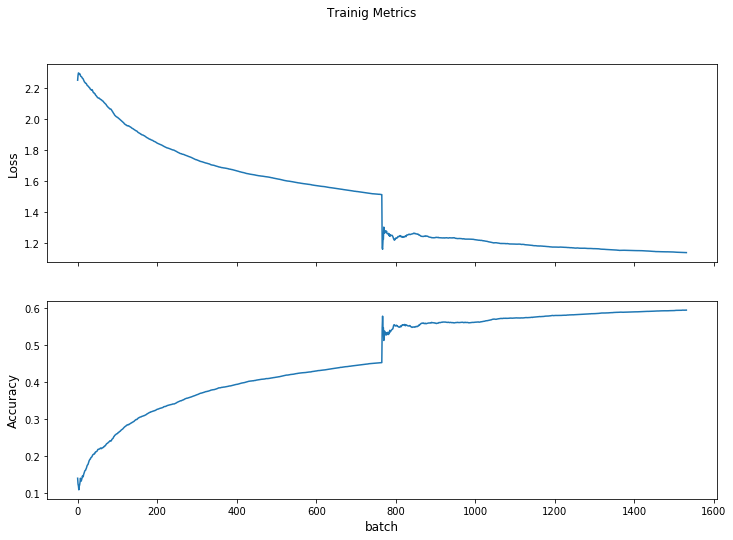

In [21]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Trainig Metrics')

axes[0].set_ylabel("Loss", fontsize = 12)
axes[0].plot(train_loss_batch)

axes[1].set_ylabel("Accuracy" , fontsize = 12)
axes[1].set_xlabel("batch", fontsize = 12)
axes[1].plot(train_accuracy_batch)

plt.show()


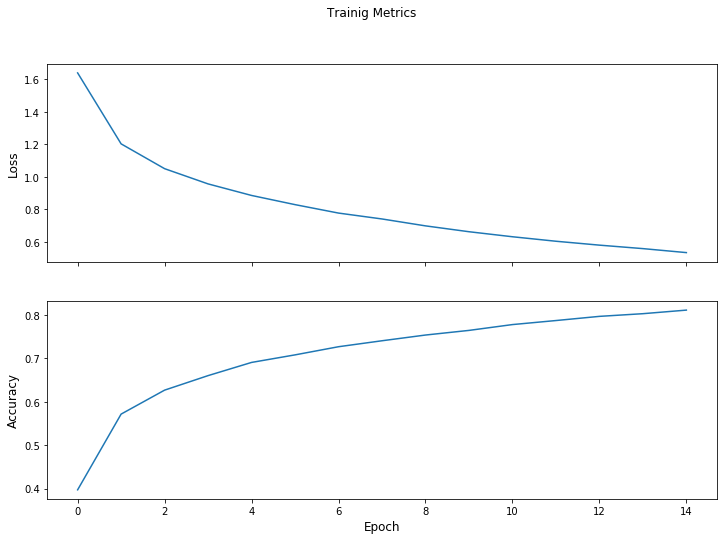

In [55]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Trainig Metrics')

axes[0].set_ylabel("Loss", fontsize = 12)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy" , fontsize = 12)
axes[1].set_xlabel("Epoch", fontsize = 12)
axes[1].plot(train_accuracy_results)

plt.show()